In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from timm import create_model
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter

# Inline plotting for Jupyter
%matplotlib inline

# Warnings filter (optional)
import warnings
warnings.filterwarnings("ignore")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
data_dir = r'D:\cervical cancer image dataset\archive'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

# Handle class imbalance
class_counts = Counter(dataset.targets)
total_samples = sum(class_counts.values())
class_weights = torch.tensor(
    [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)],
    dtype=torch.float
).to(device)


In [19]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [20]:
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [21]:
num_epochs = 10
best_val_loss = float('inf')
patience, trials = 5, 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trials = 0
        torch.save(model.state_dict(), 'vit_sipakmed_best.pth')
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered.")
            break
    scheduler.step()


Epoch 1/10, Train Loss: 0.8500, Train Acc: 0.6664, Val Loss: 0.4422, Val Acc: 0.8298
Epoch 2/10, Train Loss: 0.3423, Train Acc: 0.8704, Val Loss: 0.3222, Val Acc: 0.8803
Epoch 3/10, Train Loss: 0.2179, Train Acc: 0.9188, Val Loss: 0.1670, Val Acc: 0.9375
Epoch 4/10, Train Loss: 0.1532, Train Acc: 0.9430, Val Loss: 0.3033, Val Acc: 0.8910
Epoch 5/10, Train Loss: 0.1270, Train Acc: 0.9533, Val Loss: 0.2329, Val Acc: 0.9162
Epoch 6/10, Train Loss: 0.0780, Train Acc: 0.9738, Val Loss: 0.1244, Val Acc: 0.9601
Epoch 7/10, Train Loss: 0.0316, Train Acc: 0.9863, Val Loss: 0.1349, Val Acc: 0.9628
Epoch 8/10, Train Loss: 0.0209, Train Acc: 0.9923, Val Loss: 0.1379, Val Acc: 0.9641
Epoch 9/10, Train Loss: 0.0101, Train Acc: 0.9963, Val Loss: 0.1351, Val Acc: 0.9628
Epoch 10/10, Train Loss: 0.0047, Train Acc: 0.9991, Val Loss: 0.1122, Val Acc: 0.9734


In [22]:
model.load_state_dict(torch.load('vit_sipakmed_best.pth'))
model.eval()

test_correct, test_total = 0, 0
all_preds, all_labels, all_probs = [], [], []
features = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        features.extend(model.forward_features(images)[:, 0].cpu().numpy())

print(f'Test Accuracy: {test_correct/test_total:.4f}')


Test Accuracy: 0.9655


In [23]:
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}')

auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
print(f'AUC-ROC: {auc:.4f}')


im_Dyskeratotic: Precision=0.9801, Recall=0.9548, F1=0.9673
im_Koilocytotic: Precision=0.9245, Recall=0.9484, F1=0.9363
im_Metaplastic: Precision=0.9540, Recall=0.9486, F1=0.9513
im_Parabasal: Precision=0.9919, Recall=0.9919, F1=0.9919
im_Superficial-Intermediate: Precision=0.9862, Recall=0.9931, F1=0.9896
AUC-ROC: 0.9987


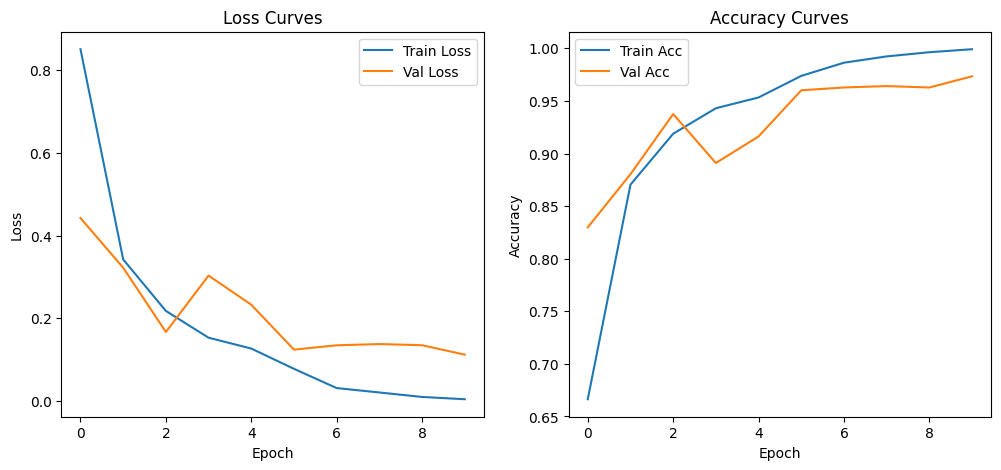

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


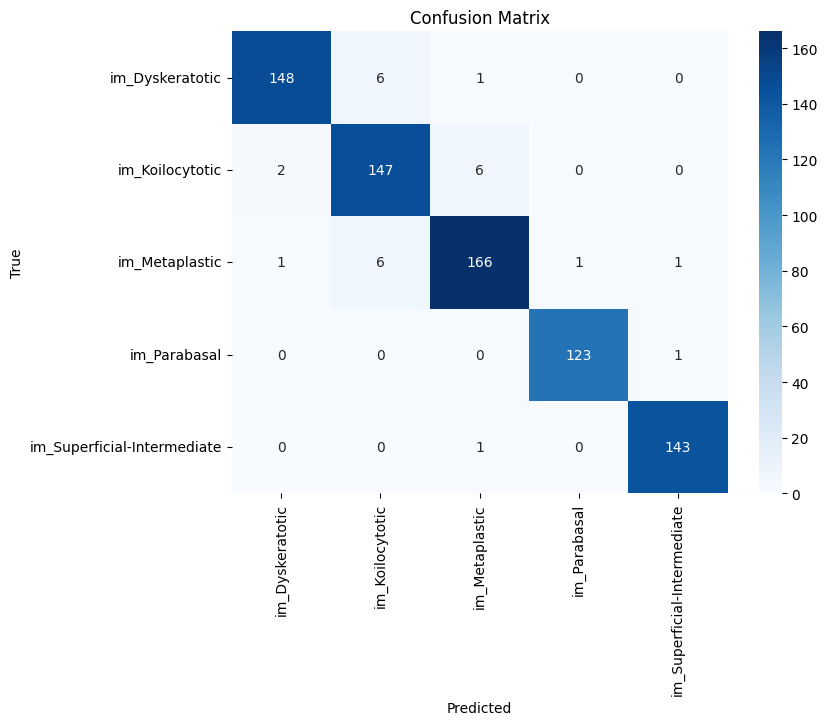

In [25]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


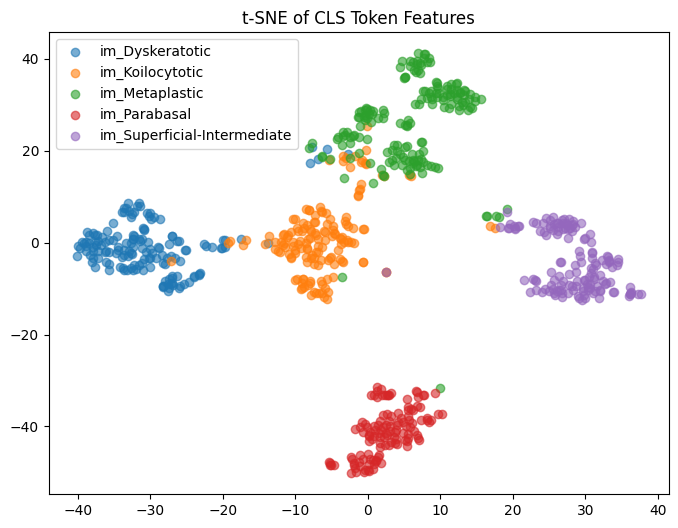

In [26]:
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(features))

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    idx = np.where(np.array(all_labels) == i)[0]
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=class_names[i], alpha=0.6)
plt.title('t-SNE of CLS Token Features')
plt.legend()
plt.show()


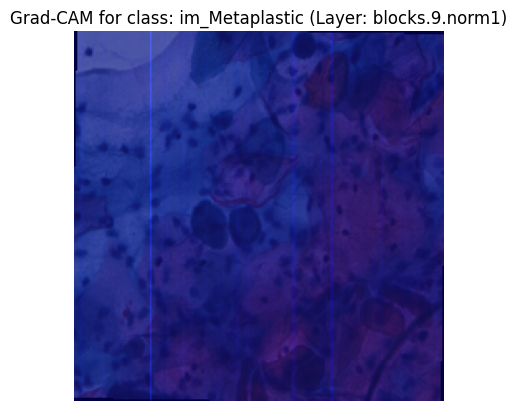

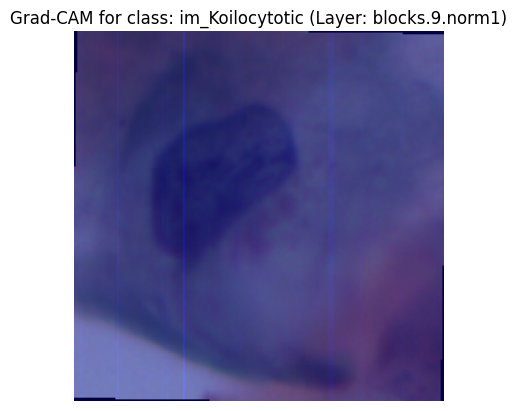

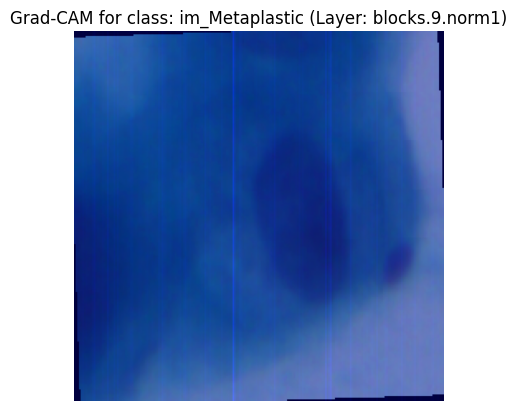

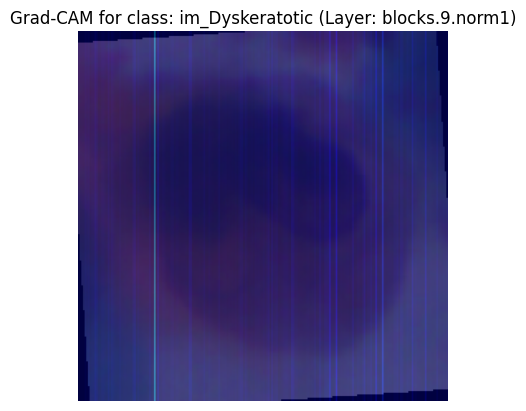

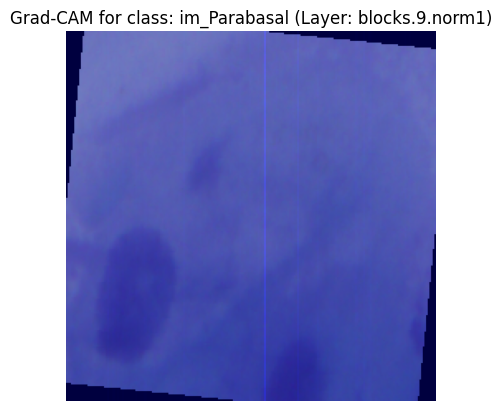

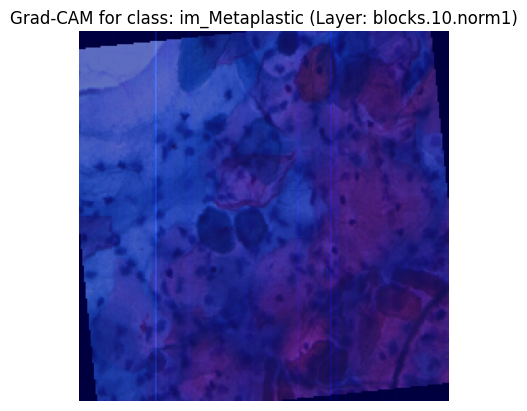

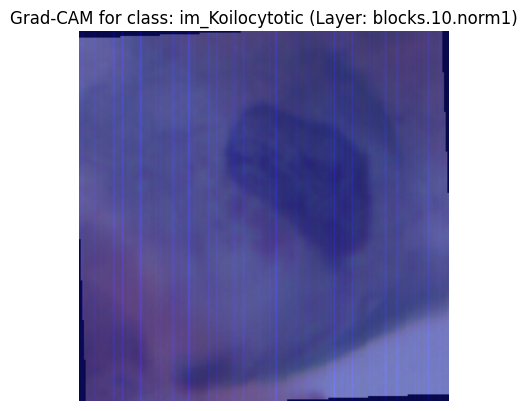

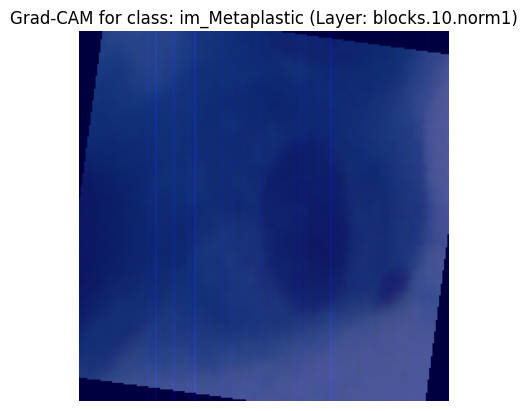

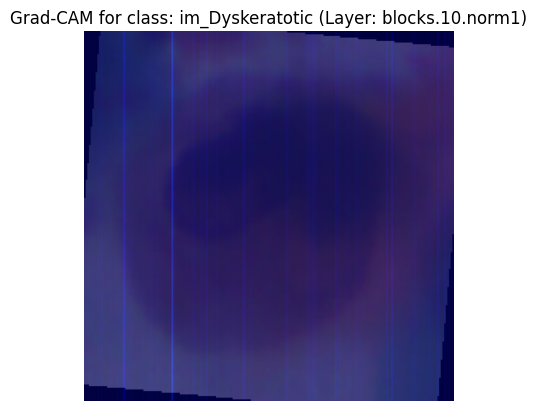

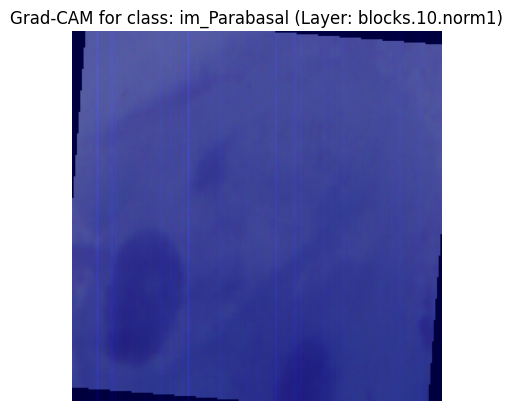

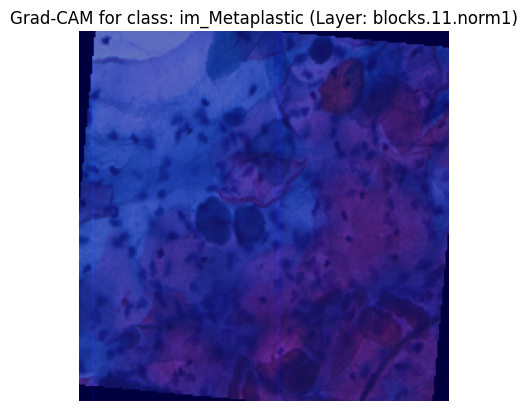

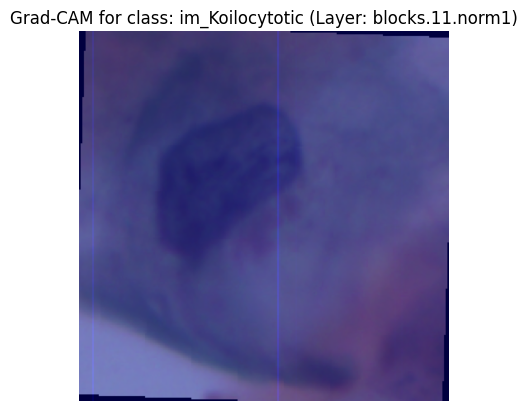

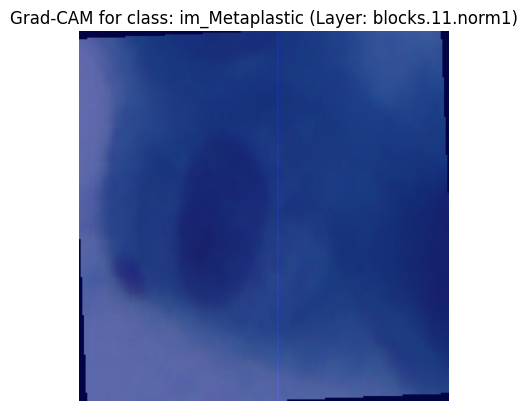

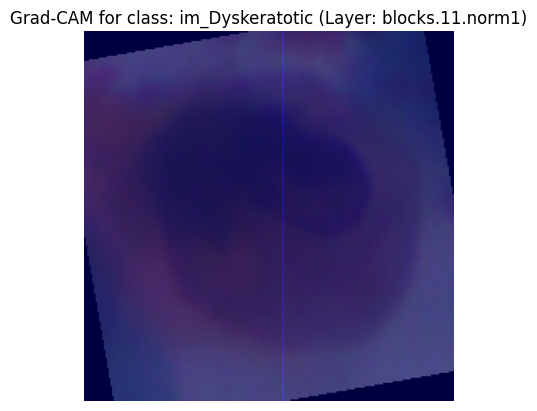

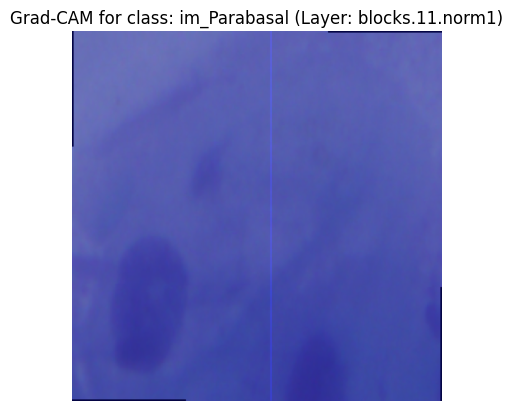

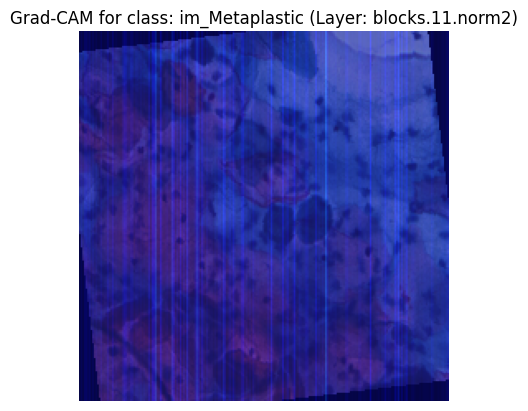

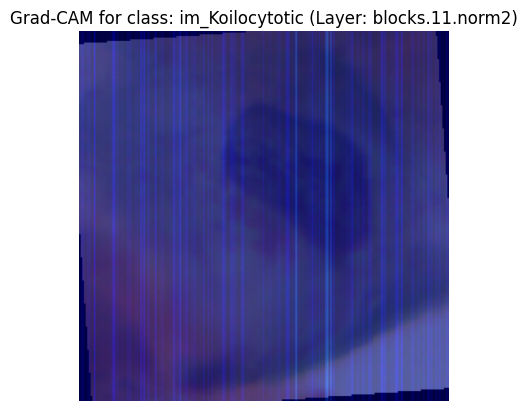

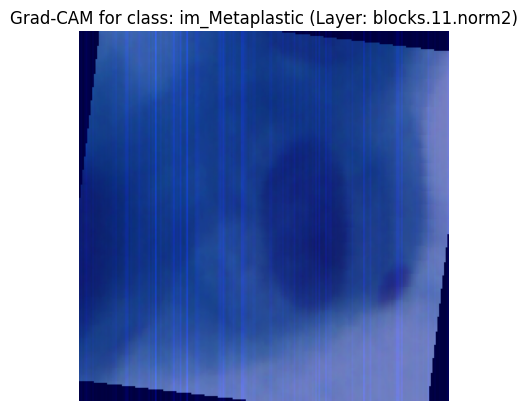

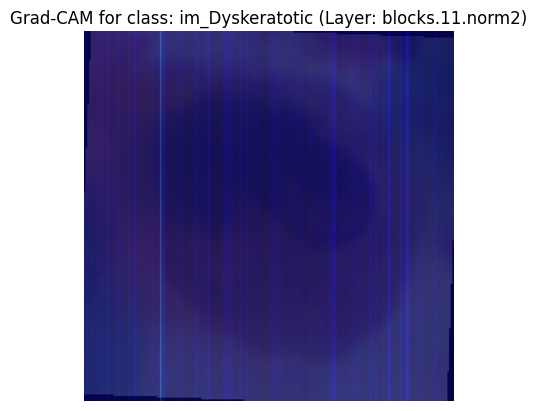

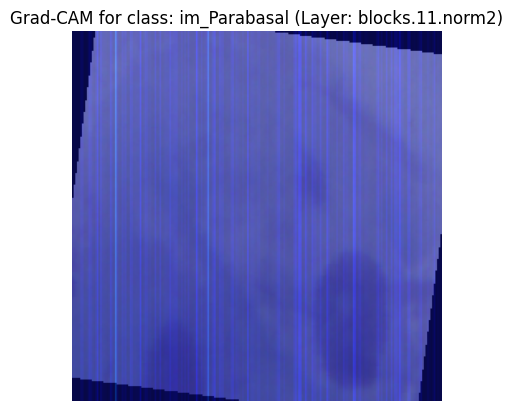

In [28]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Create output directory
os.makedirs('gradcam', exist_ok=True)

# List of layers to try
candidate_layers = ['blocks.9.norm1', 'blocks.10.norm1', 'blocks.11.norm1', 'blocks.11.norm2']

# Generate Grad-CAM for each layer
model.eval()
for layer in candidate_layers:
    cam = GradCAM(model, target_layer=layer)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:  # Limit to 5 images
            break
        image = images[0:1].to(device)
        label = labels[0].item()
        scores = model(image)
        activation_map = cam(class_idx=label, scores=scores)

        # Unnormalize image
        img_np = images[0].permute(1, 2, 0).cpu().numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))

        # Generate and save heatmap
        heatmap = overlay_mask(img_pil, Image.fromarray(activation_map[0].cpu().numpy()), alpha=0.5)
        plt.figure()
        plt.imshow(heatmap)
        plt.title(f"Grad-CAM for class: {class_names[label]} (Layer: {layer})")
        plt.axis('off')
        plt.savefig(f'gradcam/gradcam_image_{i}_class_{class_names[label]}_layer_{layer.replace(".", "_")}.png')
        plt.show()
        plt.close()